In [1]:
from google.colab import files
uploaded = files.upload()


Saving Dataset.csv to Dataset.csv


In [2]:
import pandas as pd
df = pd.read_csv('Dataset.csv')


/tmp/ipython-input-3-714340278.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21135/21148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9538 - loss: 0.1260

21148/21148 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.9538 - loss: 0.1260 - val_accuracy: 0.9681 - val_loss: 0.0922
Epoch 2/30
21133/21148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9731 - loss: 0.0729

21148/21148 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9731 - loss: 0.0729 - val_accuracy: 0.9790 - val_loss: 0.0614
Epoch 3/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9750 - loss: 0.0670 - val_accuracy: 0.9794 - val_loss: 0.0677
Epoch 4/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9766 - loss: 0.0630 - val_accuracy: 0.9777 - val_loss: 0.0662
Epoch 5/30
21132/21148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9775 - loss: 0.0618

21148/21148 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9775 - loss: 0.0618 - val_accuracy: 0.9858 - val_loss: 0.0507
Epoch 6/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9781 - loss: 0.0599 - val_accuracy: 0.9818 - val_loss: 0.0597
Epoch 7/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.9792 - loss: 0.0577 - val_accuracy: 0.9799 - val_loss: 0.0643
Epoch 8/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.9793 - loss: 0.0581 - val_accuracy: 0.9813 - val_loss: 0.0632
Epoch 9/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9794 - loss: 0.0573 - val_accuracy: 0.9829 - val_loss: 0.0560
Epoch 10/30
21148/21148 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9797 - loss: 0.0571 - val_accuracy: 0.9843 - val_loss: 0.0510
3345/3345 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9781 - loss: 0.0540

✅ Test Accuracy: 0.9778
3345/3345 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step

🔹 Confusion Matrix:
[[103440   2298]
 [    75   1223]]

🔹 Classifi

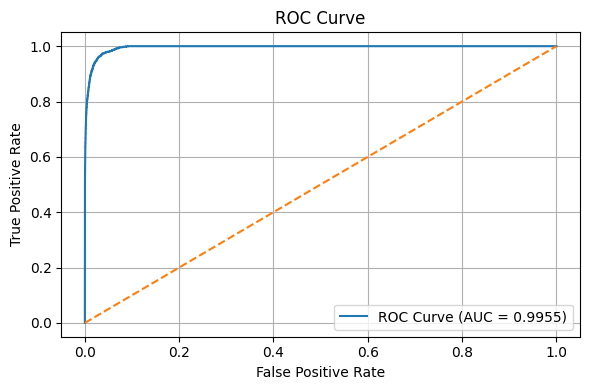

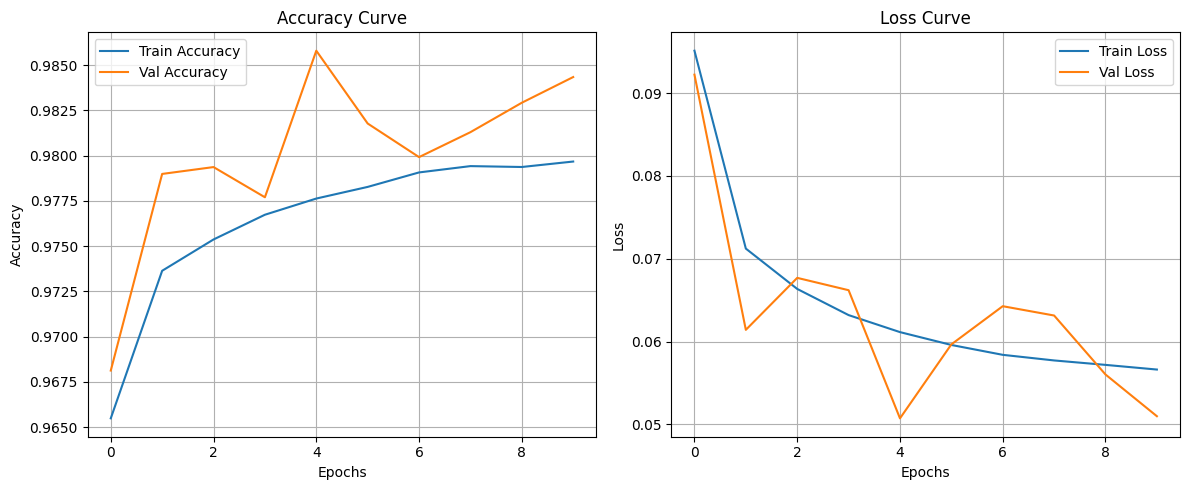

In [3]:
# Step 1: Import all required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Load the dataset
df = pd.read_csv("Dataset.csv")

# Step 3: Clean string columns (remove surrounding single quotes)
df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)

# Step 4: Encode categorical features
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Step 5: Separate features and target
if 'fraud' not in df.columns:
    raise ValueError("Target column 'fraud' not found in dataset.")
X = df.drop("fraud", axis=1)
y = df["fraud"]

# Step 6: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Train the Autoencoder on non-fraud (normal) data only
X_train_auto = X_scaled[y == 0]

input_dim = X_train_auto.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Step 8: Train the autoencoder
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_train_auto, X_train_auto,
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

# Step 9: Calculate reconstruction error
X_pred = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

# Step 10: Set threshold using reconstruction error from training data
threshold = np.percentile(reconstruction_error[y == 0], 95)

# Step 11: Make predictions
y_pred = (reconstruction_error > threshold).astype(int)

# Step 12: Evaluation
print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y, y_pred))

report = classification_report(y, y_pred, output_dict=True)
print(f"\n🔹 Overall Precision: {report['weighted avg']['precision']:.4f}")
print(f"🔹 Overall Recall:    {report['weighted avg']['recall']:.4f}")
print(f"🔹 Overall F1-score:  {report['weighted avg']['f1-score']:.4f}")

roc_auc = roc_auc_score(y, reconstruction_error)
print(f"🔹 ROC-AUC Score:     {roc_auc:.4f}")

# Step 13: Plot ROC Curve
fpr, tpr, _ = roc_curve(y, reconstruction_error)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Autoencoder)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Step 14: Training Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


/tmp/ipython-input-6-1843090872.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)


🔹 Training Autoencoder on entire dataset...
🔹 Autoencoder Architecture:
   Input dimension: 9
   Encoding dimension: 14
   Total parameters: 275
Epoch 1/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.5293
Epoch 2/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.4878
Epoch 3/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.4852
Epoch 4/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.4955
Epoch 5/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.4813
Epoch 6/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.4937
Epoch 7/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.4892
Epoch 8/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.4812
Epoch 9/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.4842
Epoch 10/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 0.4844
Epoch 11/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.4842
Epoch 12/20
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - l

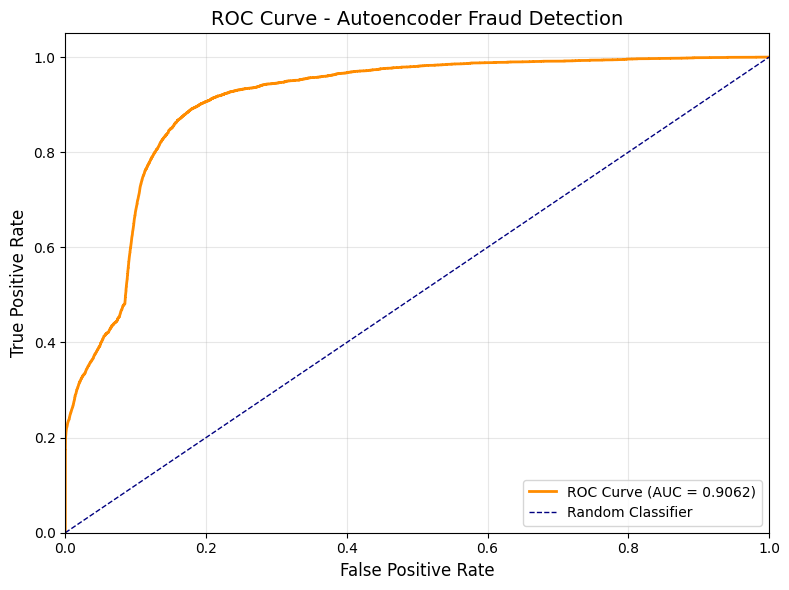

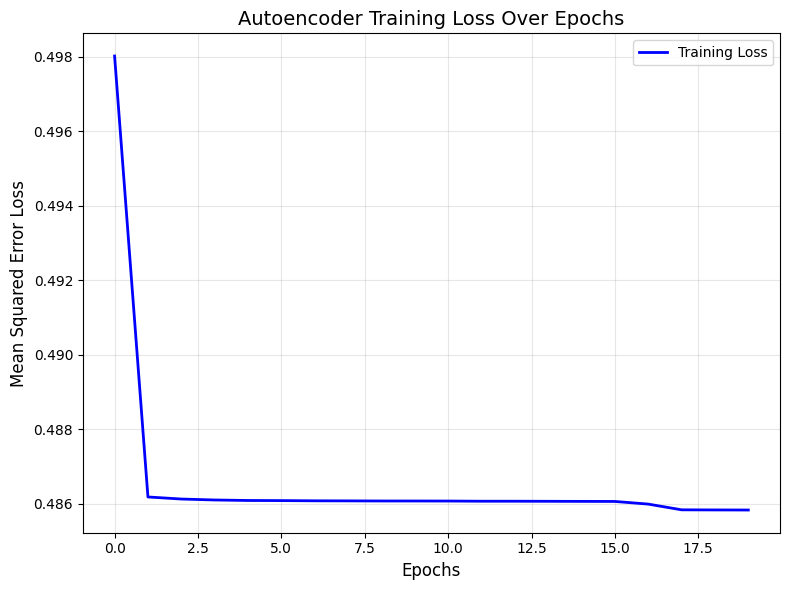

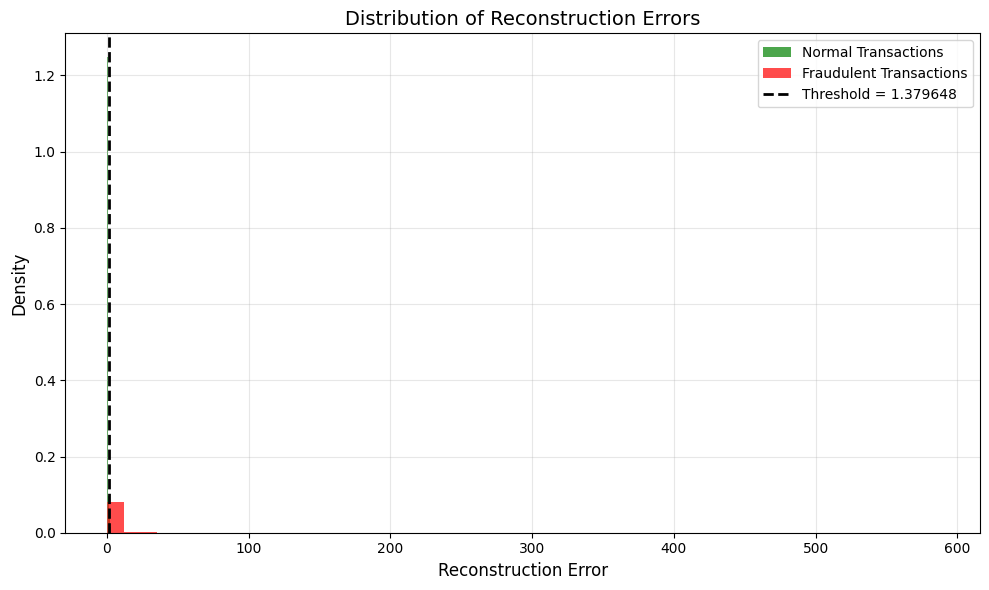


🔹 Analysis Complete!
🔹 Model trained on 535178 total samples
🔹 Normal transactions: 528686
🔹 Fraudulent transactions: 6492


In [6]:
# Step 1: Import all required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Load the dataset
df = pd.read_csv("Dataset.csv")

# Step 3: Clean string columns (remove surrounding single quotes)
df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)

# Step 4: Encode categorical features
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Step 5: Separate features and target
if 'fraud' not in df.columns:
    raise ValueError("Target column 'fraud' not found in dataset.")
X = df.drop("fraud", axis=1)
y = df["fraud"]

# Step 6: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Train the Autoencoder on entire dataset (both normal and fraud data)
print("🔹 Training Autoencoder on entire dataset...")

input_dim = X_scaled.shape[1]
encoding_dim = 14

# Define autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Create and compile the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print(f"🔹 Autoencoder Architecture:")
print(f"   Input dimension: {input_dim}")
print(f"   Encoding dimension: {encoding_dim}")
print(f"   Total parameters: {autoencoder.count_params()}")

# Step 8: Train the autoencoder on entire dataset
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_scaled, X_scaled,  # Training on entire dataset
    epochs=20,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

print(f"🔹 Training completed in {len(history.history['loss'])} epochs")

# Step 9: Calculate reconstruction error for all data
print("🔹 Calculating reconstruction errors...")
X_pred = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

# Step 10: Set threshold using reconstruction error from normal data
normal_errors = reconstruction_error[y == 0]
threshold = np.percentile(normal_errors, 95)  # 95th percentile of normal data errors

print(f"🔹 Threshold set at: {threshold:.6f}")
print(f"🔹 Normal data reconstruction error - Mean: {np.mean(normal_errors):.6f}, Std: {np.std(normal_errors):.6f}")

# Step 11: Make predictions based on reconstruction error threshold
y_pred = (reconstruction_error > threshold).astype(int)

# Step 12: Evaluation
print("\n" + "="*50)
print("🔹 MODEL EVALUATION RESULTS")
print("="*50)

print("\n🔹 Confusion Matrix:")
cm = confusion_matrix(y, y_pred)
print(cm)

print(f"\n🔹 Fraud Detection Summary:")
print(f"   True Negatives:  {cm[0,0]}")
print(f"   False Positives: {cm[0,1]}")
print(f"   False Negatives: {cm[1,0]}")
print(f"   True Positives:  {cm[1,1]}")

report = classification_report(y, y_pred, output_dict=True)
print(f"\n🔹 Overall Precision: {report['weighted avg']['precision']:.4f}")
print(f"🔹 Overall Recall:    {report['weighted avg']['recall']:.4f}")
print(f"🔹 Overall F1-score:  {report['weighted avg']['f1-score']:.4f}")

roc_auc = roc_auc_score(y, reconstruction_error)
print(f"🔹 ROC-AUC Score:     {roc_auc:.4f}")

# Step 13: Plot ROC Curve
fpr, tpr, _ = roc_curve(y, reconstruction_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Autoencoder Fraud Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 14: Training Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], color='blue', linewidth=2, label='Training Loss')
plt.title('Autoencoder Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 15: Additional Analysis - Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error[y == 0], bins=50, alpha=0.7, label='Normal Transactions', color='green', density=True)
plt.hist(reconstruction_error[y == 1], bins=50, alpha=0.7, label='Fraudulent Transactions', color='red', density=True)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.6f}')
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Reconstruction Errors', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔹 Analysis Complete!")
print(f"🔹 Model trained on {len(X_scaled)} total samples")
print(f"🔹 Normal transactions: {len(y[y==0])}")
print(f"🔹 Fraudulent transactions: {len(y[y==1])}")

/tmp/ipython-input-7-3853952538.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)


🔹 Training Autoencoder on entire dataset...
🔹 Autoencoder Architecture:
   Input dimension: 9
   Encoding dimension: 14
   Total parameters: 275
Epoch 1/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.5398
Epoch 2/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.4907
Epoch 3/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.4883
Epoch 4/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.4824
Epoch 5/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.4790
Epoch 6/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.4886
Epoch 7/7
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.4866
🔹 Training completed in 7 epochs
🔹 Calculating reconstruction errors...
16725/16725 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
🔹 Threshold set at: 1.379744
🔹 Normal data reconstruction error - Mean: 0.390362, Std: 0.432947

🔹 MODEL EVALUATION RESULTS

🔹 Confusion Matrix:
[[502251  26435]
 [  3915   2577]]

🔹 Fraud Detection Summary:
   True Negatives:  502251
   Fa

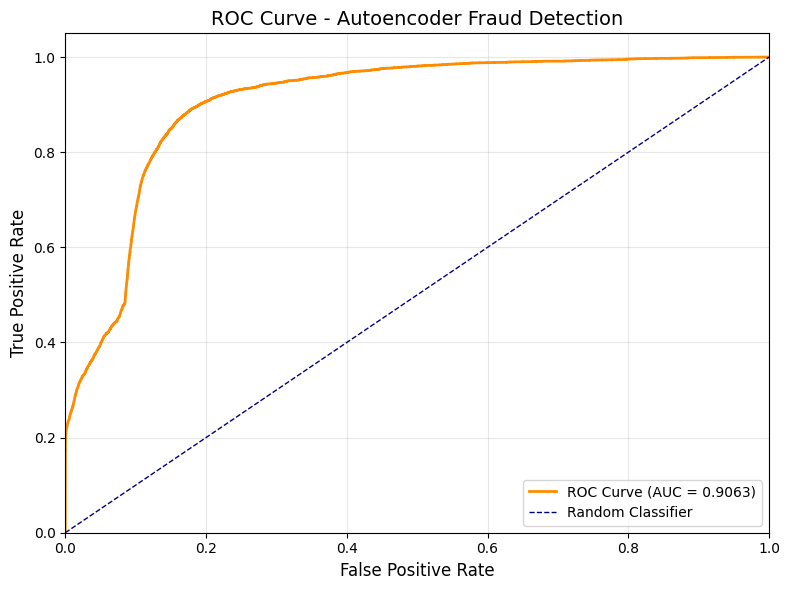

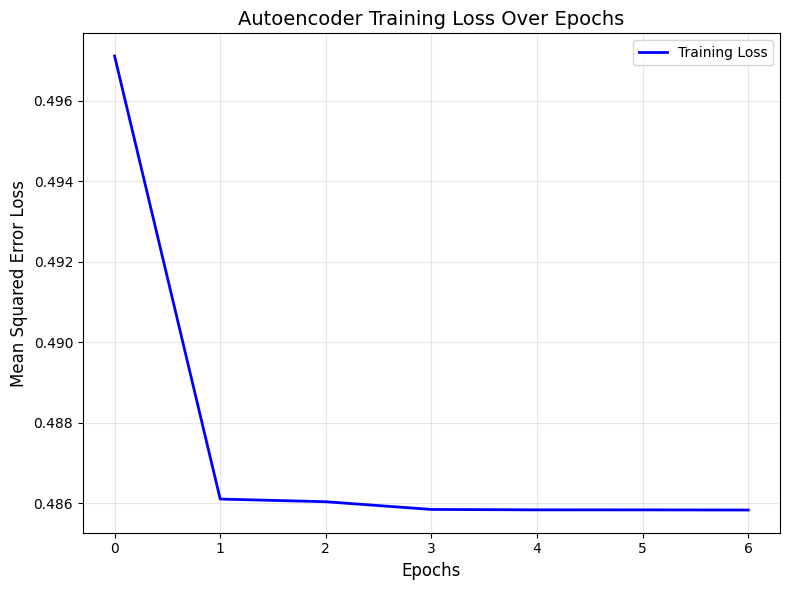

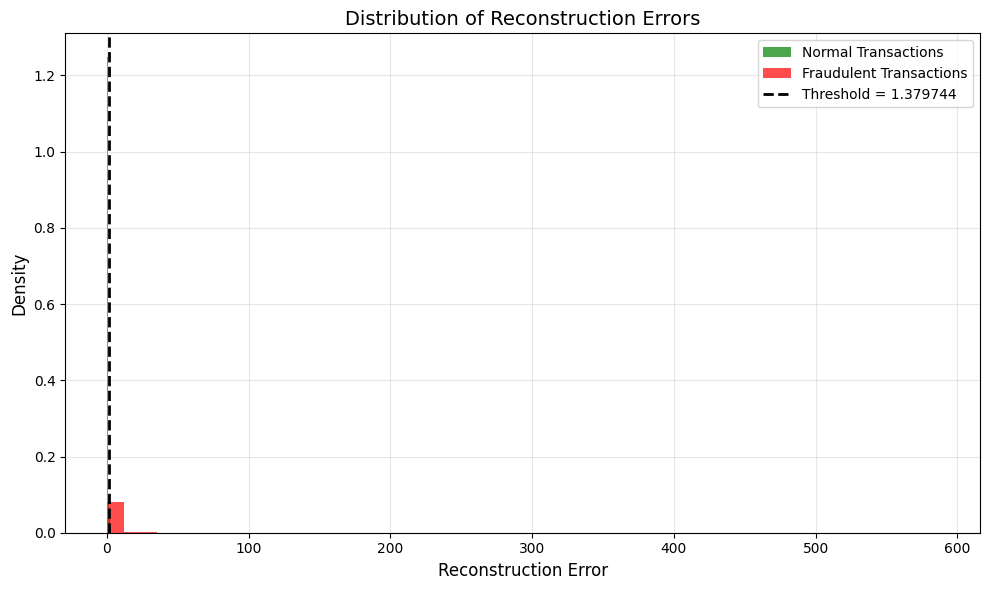

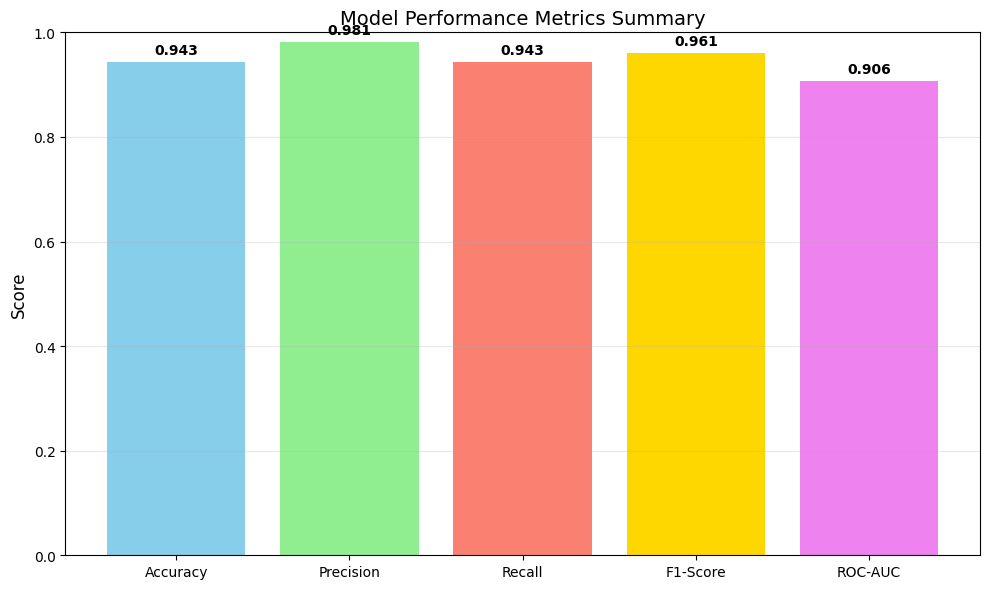


🔹 Final Model Summary:
🎯 MODEL ACCURACY: 0.9433 (94.33%)
🔹 Model trained on 535178 total samples
🔹 Normal transactions: 528686 (98.8%)
🔹 Fraudulent transactions: 6492 (1.2%)
🔹 Correctly classified: 504828.0 out of 535178 samples


In [7]:
# Step 1: Import all required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score  # Added for accuracy calculation
)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Load the dataset
df = pd.read_csv("Dataset.csv")

# Step 3: Clean string columns (remove surrounding single quotes)
df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)

# Step 4: Encode categorical features
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Step 5: Separate features and target
if 'fraud' not in df.columns:
    raise ValueError("Target column 'fraud' not found in dataset.")
X = df.drop("fraud", axis=1)
y = df["fraud"]

# Step 6: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Train the Autoencoder on entire dataset (both normal and fraud data)
print("🔹 Training Autoencoder on entire dataset...")

input_dim = X_scaled.shape[1]
encoding_dim = 14

# Define autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Create and compile the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print(f"🔹 Autoencoder Architecture:")
print(f"   Input dimension: {input_dim}")
print(f"   Encoding dimension: {encoding_dim}")
print(f"   Total parameters: {autoencoder.count_params()}")

# Step 8: Train the autoencoder on entire dataset
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    X_scaled, X_scaled,  # Training on entire dataset
    epochs=7,
    batch_size=32,
    shuffle=True,
    callbacks=[early_stop],
    verbose=1
)

print(f"🔹 Training completed in {len(history.history['loss'])} epochs")

# Step 9: Calculate reconstruction error for all data
print("🔹 Calculating reconstruction errors...")
X_pred = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

# Step 10: Set threshold using reconstruction error from normal data
normal_errors = reconstruction_error[y == 0]
threshold = np.percentile(normal_errors, 95)  # 95th percentile of normal data errors

print(f"🔹 Threshold set at: {threshold:.6f}")
print(f"🔹 Normal data reconstruction error - Mean: {np.mean(normal_errors):.6f}, Std: {np.std(normal_errors):.6f}")

# Step 11: Make predictions based on reconstruction error threshold
y_pred = (reconstruction_error > threshold).astype(int)

# Step 12: Evaluation with Accuracy
print("\n" + "="*50)
print("🔹 MODEL EVALUATION RESULTS")
print("="*50)

print("\n🔹 Confusion Matrix:")
cm = confusion_matrix(y, y_pred)
print(cm)

print(f"\n🔹 Fraud Detection Summary:")
print(f"   True Negatives:  {cm[0,0]}")
print(f"   False Positives: {cm[0,1]}")
print(f"   False Negatives: {cm[1,0]}")
print(f"   True Positives:  {cm[1,1]}")

# Calculate Accuracy
accuracy = accuracy_score(y, y_pred)
print(f"\n🔹 MODEL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Calculate other metrics
report = classification_report(y, y_pred, output_dict=True)
print(f"\n🔹 Detailed Performance Metrics:")
print(f"   Overall Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Overall Precision: {report['weighted avg']['precision']:.4f}")
print(f"   Overall Recall:    {report['weighted avg']['recall']:.4f}")
print(f"   Overall F1-score:  {report['weighted avg']['f1-score']:.4f}")

# Class-wise metrics
print(f"\n🔹 Class-wise Performance:")
print(f"   Normal Class (0):")
print(f"      Precision: {report['0']['precision']:.4f}")
print(f"      Recall:    {report['0']['recall']:.4f}")
print(f"      F1-score:  {report['0']['f1-score']:.4f}")

print(f"   Fraud Class (1):")
print(f"      Precision: {report['1']['precision']:.4f}")
print(f"      Recall:    {report['1']['recall']:.4f}")
print(f"      F1-score:  {report['1']['f1-score']:.4f}")

roc_auc = roc_auc_score(y, reconstruction_error)
print(f"\n🔹 ROC-AUC Score: {roc_auc:.4f}")

# Additional accuracy calculations
print(f"\n🔹 Additional Accuracy Metrics:")
sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])  # True Positive Rate
specificity = cm[0,0] / (cm[0,0] + cm[0,1])  # True Negative Rate
print(f"   Sensitivity (Recall): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity:          {specificity:.4f} ({specificity*100:.2f}%)")

# Step 13: Plot ROC Curve
fpr, tpr, _ = roc_curve(y, reconstruction_error)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Autoencoder Fraud Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 14: Training Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], color='blue', linewidth=2, label='Training Loss')
plt.title('Autoencoder Training Loss Over Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 15: Additional Analysis - Reconstruction Error Distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error[y == 0], bins=50, alpha=0.7, label='Normal Transactions', color='green', density=True)
plt.hist(reconstruction_error[y == 1], bins=50, alpha=0.7, label='Fraudulent Transactions', color='red', density=True)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.6f}')
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Reconstruction Errors', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 16: Performance Summary Chart
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [
    accuracy,
    report['weighted avg']['precision'],
    report['weighted avg']['recall'],
    report['weighted avg']['f1-score'],
    roc_auc
]

bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold', 'violet'])
plt.ylim(0, 1.0)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics Summary', fontsize=14)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\n🔹 Final Model Summary:")
print("="*50)
print(f"🎯 MODEL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🔹 Model trained on {len(X_scaled)} total samples")
print(f"🔹 Normal transactions: {len(y[y==0])} ({len(y[y==0])/len(y)*100:.1f}%)")
print(f"🔹 Fraudulent transactions: {len(y[y==1])} ({len(y[y==1])/len(y)*100:.1f}%)")
print(f"🔹 Correctly classified: {accuracy_score(y, y_pred, normalize=False)} out of {len(y)} samples")
print("="*50)

In [8]:
# Save the trained Keras model
autoencoder.save("autoencoder_model.h5")


In [9]:
import joblib

# Save the fitted scaler
joblib.dump(scaler, "scaler.save")


['scaler.save']

In [10]:
# Save the threshold to a text file
with open("threshold.txt", "w") as f:
    f.write(str(threshold))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    accuracy_score
)
from tensorflow.keras.models import load_model
import time

# Load the saved model
model = load_model('autoencoder_model.h5')
print("✅ Model loaded successfully")

# Load and prepare test data
test_df = pd.read_csv('test.csv')

# Separate features and labels
X_test = test_df.drop(['Class'], axis=1)
y_test = test_df['Class'].values

# Apply the same preprocessing (assumes StandardScaler was used)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Predict reconstruction on test set
start_time = time.time()
reconstructions = model.predict(X_test_scaled, verbose=0)
errors = np.mean(np.square(X_test_scaled - reconstructions), axis=1)
print("🔹 Reconstruction completed in {:.2f} seconds".format(time.time() - start_time))

# Set threshold (use same threshold used during training, or calculate from normal data if needed)
THRESHOLD = 1.379744

# Predict class labels
y_pred = [1 if err > THRESHOLD else 0 for err in errors]

# Evaluation
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
roc_score = roc_auc_score(y_test, errors)

# Detailed class-wise metrics
report = classification_report(y_test, y_pred, output_dict=True)

print("\n" + "="*50)
print("🔹 MODEL EVALUATION RESULTS")
print("="*50)
print("\n🔹 Confusion Matrix:")
print(conf_matrix)

print(f"\n🔹 Fraud Detection Summary:")
print(f"   True Negatives:  {tn}")
print(f"   False Positives: {fp}")
print(f"   False Negatives: {fn}")
print(f"   True Positives:  {tp}")

print(f"\n🔹 MODEL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\n🔹 Detailed Performance Metrics:")
print(f"   Overall Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Overall Precision: {precision:.4f}")
print(f"   Overall Recall:    {recall:.4f}")
print(f"   Overall F1-score:  {f1:.4f}")

print(f"\n🔹 Class-wise Performance:")
print(f"   Normal Class (0):")
print(f"      Precision: {report['0']['precision']:.4f}")
print(f"      Recall:    {report['0']['recall']:.4f}")
print(f"      F1-score:  {report['0']['f1-score']:.4f}")
print(f"   Fraud Class (1):")
print(f"      Precision: {report['1']['precision']:.4f}")
print(f"      Recall:    {report['1']['recall']:.4f}")
print(f"      F1-score:  {report['1']['f1-score']:.4f}")

print(f"\n🔹 ROC-AUC Score: {roc_score:.4f}")

print(f"\n🔹 Additional Accuracy Metrics:")
print(f"   Sensitivity (Recall): {report['1']['recall']:.4f} ({report['1']['recall']*100:.2f}%)")
print(f"   Specificity:          {report['0']['recall']:.4f} ({report['0']['recall']*100:.2f}%)")

print("\n" + "="*50)
print("🎯 FINAL MODEL SUMMARY:")
print("="*50)
print(f"🎯 MODEL ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🔹 Total test samples: {len(y_test)}")
print(f"🔹 Normal transactions: {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"🔹 Fraudulent transactions: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")
print(f"🔹 Correctly classified: {(y_test == y_pred).sum()} out of {len(y_test)} samples")
